In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns; sns.set(font_scale=1.7) 
import matplotlib.pyplot as plt
import sklearn
import statsmodels.api as sm
import math
import json
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier 
import xgboost as xgb
import re
from sklearn.metrics import log_loss
%matplotlib inline

# Data Cleaning & Feature Engineering

### Read in JSON data, combine into one dataframe total

In [2]:
json_obj = json.load(open('../Data/train.json'))
json_obj.keys()

dict_keys(['display_address', 'building_id', 'latitude', 'interest_level', 'created', 'longitude', 'manager_id', 'bathrooms', 'photos', 'listing_id', 'bedrooms', 'price', 'description', 'features', 'street_address'])

In [3]:
train =pd.DataFrame()
for key in json_obj.keys():
    train[key] = pd.Series(json_obj[key])

In [4]:
json_obj2 = json.load(open('../Data/test.json'))
test = pd.DataFrame()
for key in json_obj2.keys():
    test[key] = pd.Series(json_obj2[key])

In [5]:
train_ori_index = train.index
test_ori_index = test.index

In [6]:
train['label'] = 'Train'
test['label'] = 'Test'
total = pd.concat([train, test], axis = 0)

In [7]:
listing_image = pd.read_csv('listing_image_time.csv')

In [8]:
listing_image.head()

,Listing_Id,time_stamp
0,6811957,1479785186
1,6811958,1479786880
2,6811960,1479780964
3,6811964,1479783510
4,6811965,1479786168


In [9]:
total = pd.merge(total, listing_image, left_on = 'listing_id', right_on = 'Listing_Id', how = 'left')

In [10]:
total = total.drop('Listing_Id', axis = 1)

### Covert 'Created' to 'Date' datetime format

In [11]:
import datetime as dt
def get_datetime(strings):
    try:
        date = dt.datetime.strptime(strings, '%Y-%m-%d %H:%M:%S')
        return date
    except:
        return None

In [12]:
total['date'] = total['created'].apply(get_datetime)

In [13]:
def get_month(dt):
    try:
        return dt.month
    except:
        return None

In [14]:
total['month'] = total['date'].apply(get_month)

In [15]:
day_min = total['date'].min()

In [16]:
def get_timediff(date):
    return (date - day_min).days

In [17]:
total['day_diff'] = total['date'].apply(get_timediff)

### Deal with 'photos', 'descriptions'

In [18]:
total['photos_counts'] = total['photos'].apply(len)

In [19]:
total['description_word_count'] = total['description'].apply(lambda x:len(x.split(" ")))

### Deal with Categorical Features: 

In [20]:
from sklearn import preprocessing

In [21]:
categorical = ["display_address", "manager_id", "building_id", "street_address"]
for f in categorical:
        if total[f].dtype=='object':
            #print(f)
            lbl = preprocessing.LabelEncoder()
            total[f] = lbl.fit_transform(total[f])

### Deal with features

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [23]:
total.ix[1000,'features']

['Swimming Pool',
 'Roof Deck',
 'Doorman',
 'Elevator',
 'Fitness Center',
 'Laundry in Building',
 'High Speed Internet',
 'Dishwasher',
 'Hardwood Floors',
 'No Fee',
 'Dogs Allowed',
 'Cats Allowed']

In [24]:
total['features2'] = total['features'].apply(lambda x:' '.join(['_'.join(i.split(" ")) for i in x]))

In [25]:
cv = CountVectorizer(stop_words='english', max_features=200)

In [26]:
total_cvfeatures = pd.DataFrame(cv.fit_transform(total['features2']).toarray())
total_cvfeatures.index = total.index

In [27]:
total = pd.concat([total, total_cvfeatures], axis = 1)

In [28]:
#  def clean(text):
#     clean1 = re.sub('[^a-zA-Z0-9]',' ',text)
#     clean2 = re.sub(' +', ' ', clean1)
#     clean3 = clean2.lower()
#     return clean3


In [29]:
## tfidf = TfidfVectorizer(max_features= 500, stop_words= 'english')

#  total['features2'] = total['features'].apply(' '.join)

# # total_features = tfidf.fit_transform(total['features2'])

# total_features = pd.DataFrame(total_features.toarray())
# total_features.index = total.index

# total = pd.concat([total, total_features], axis = 1)



### Deal with price

In [30]:
total['total_room'] = total['bedrooms'] + total['bathrooms']

In [31]:
total['price_per_room'] = total['price'] / total['total_room']

### Deal with manager_id

In [32]:
for month in [4,5,6]:
    month_count = total.ix[total['month'] == month, ['manager_id','listing_id']].groupby('manager_id').count()
    month_count.columns = month_count.columns.str.replace('listing_id', 'listings_by_month_'+str(month))
    total = pd.merge(total, month_count, left_on = 'manager_id', right_index = True, how = 'left')

In [33]:
total['manager_listings'] = total.groupby('manager_id')['listing_id'].transform('count')

In [34]:
total.shape

(124011, 229)

In [35]:
total['listings_by_month_4_perc'] = total['listings_by_month_4'] / total['manager_listings']
total['listings_by_month_5_perc'] = total['listings_by_month_5'] / total['manager_listings']
total['listings_by_month_6_perc'] = total['listings_by_month_6'] / total['manager_listings']

In [36]:
total_2 = total.copy()

In [37]:
total_2.shape

(124011, 232)

In [38]:
total = total_2

In [39]:
total.shape

(124011, 232)

In [40]:
total['average_price_by_manager'] = total.groupby('manager_id')['price'].transform('mean')

In [41]:
for month in [4,5,6]:
    month_price = total.ix[total['month'] == month, ['manager_id','price']].groupby('manager_id').mean()
    month_price.columns = month_price.columns.str.replace('price', 'price_by_month_'+str(month))
    total = pd.merge(total, month_price, left_on = 'manager_id', right_index = True, how = 'left')

In [42]:
total.shape

(124011, 236)

### Add listings count by interest level

In [43]:
from sklearn.model_selection import KFold

In [44]:
kfold = KFold(n_splits=5, shuffle=True)

In [45]:
train = total[total['label'] == 'Train']
test = total[total['label'] == 'Test']

In [46]:
for count, (tr_index, te_index) in enumerate(kfold.split(train)):
    train_tr = train.iloc[tr_index]
    train_val = train.iloc[te_index]
    for level in train['interest_level'].unique():
        listing_count = train_tr.ix[train_tr['interest_level'] == level, ['manager_id','listing_id']].groupby('manager_id').count()
        listing_count.columns = listing_count.columns.str.replace('listing_id', 'listing_count_'+ str(level))
        train_val= pd.merge(train_val,  listing_count, left_on = 'manager_id', right_index = True, how = 'left')
    listing_count_alllevel = train_tr.ix[:,['manager_id','listing_id']].groupby('manager_id').count()
    listing_count_alllevel.columns = listing_count_alllevel.columns.str.replace('listing_id', 'listing_count')
    train_val= pd.merge(train_val,  listing_count_alllevel, left_on = 'manager_id', right_index = True, how = 'left')
    if count == 0:
        train_new = train_val
    else:
        train_new = pd.concat((train_new, train_val), axis = 0)


In [47]:
train_new.shape

(49352, 240)

In [48]:
for level in train['interest_level'].unique():
        listing_count = train.ix[train['interest_level'] == level, ['manager_id','listing_id']].groupby('manager_id').count()
        listing_count.columns = listing_count.columns.str.replace('listing_id', 'listing_count_'+ str(level))
        test= pd.merge(test,  listing_count, left_on = 'manager_id', right_index = True, how = 'left')
listing_count_alllevel = train.ix[:, ['manager_id','listing_id']].groupby('manager_id').count()
listing_count_alllevel.columns = listing_count_alllevel.columns.str.replace('listing_id', 'listing_count')
test = pd.merge(test,  listing_count_alllevel, left_on = 'manager_id', right_index = True, how = 'left')

In [49]:
test.shape

(74659, 240)

In [50]:
train_new['listing_count_high_perc'] = train_new['listing_count_high'] / train_new['listing_count']
train_new['listing_count_medium_perc'] = train_new['listing_count_medium'] / train_new['listing_count']
train_new['listing_count_low_perc'] = train_new['listing_count_low'] / train_new['listing_count']


In [51]:
test['listing_count_high_perc'] = test['listing_count_high'] / test['listing_count']
test['listing_count_medium_perc'] = test['listing_count_medium'] / test['listing_count']
test['listing_count_low_perc'] = test['listing_count_low'] / test['listing_count']


In [52]:
total = pd.concat([train_new, test], axis = 0)

In [53]:
total.shape

(124011, 243)

In [54]:
train = total[total['label'] == 'Train']
test = total[total['label'] == 'Test']

for count, (tr_index, te_index) in enumerate(kfold.split(total[total['label'] == 'Train'])):
    train_tr = train.iloc[tr_index]
    train_val = train.iloc[te_index]
    for level in train['interest_level'].unique():
        price = train_tr.ix[train_tr['interest_level'] == level, ['manager_id','price']].groupby('manager_id').mean()
        price.columns = price.columns.str.replace('price', 'price_average_'+ str(level))
        train_val= pd.merge(train_val,  price, left_on = 'manager_id', right_index = True, how = 'left')  
    if count == 0:
        train_new = train_val
    else:
        train_new = pd.concat((train_new, train_val), axis = 0)


In [55]:
for level in train['interest_level'].unique():
        price = train.ix[train['interest_level'] == level, ['manager_id','price']].groupby('manager_id').mean()
        price.columns = price.columns.str.replace('price', 'price_average_'+ str(level))
        test= pd.merge(test,  price, left_on = 'manager_id', right_index = True, how = 'left')

In [56]:
total = pd.concat([train_new, test], axis = 0)

In [57]:
train = total[total['label'] == 'Train']
test = total[total['label'] == 'Test']

for count, (tr_index, te_index) in enumerate(kfold.split(total[total['label'] == 'Train'])):
    train_tr = train.iloc[tr_index]
    train_val = train.iloc[te_index]
    for level in train['interest_level'].unique():
        price = train_tr.ix[train_tr['interest_level'] == level, ['manager_id','price']].groupby('manager_id').median()
        price.columns = price.columns.str.replace('price', 'price_median_'+ str(level))
        train_val= pd.merge(train_val,  price, left_on = 'manager_id', right_index = True, how = 'left')  
    if count == 0:
        train_new = train_val
    else:
        train_new = pd.concat((train_new, train_val), axis = 0)


In [58]:
for level in train['interest_level'].unique():
        price = train.ix[train['interest_level'] == level, ['manager_id','price']].groupby('manager_id').median()
        price.columns = price.columns.str.replace('price', 'price_median_'+ str(level))
        test= pd.merge(test,  price, left_on = 'manager_id', right_index = True, how = 'left')

In [59]:
total = pd.concat([train_new, test], axis = 0)

In [60]:
total.columns.tolist()

['bathrooms',
 'bedrooms',
 'building_id',
 'created',
 'description',
 'display_address',
 'features',
 'interest_level',
 'label',
 'latitude',
 'listing_id',
 'longitude',
 'manager_id',
 'photos',
 'price',
 'street_address',
 'time_stamp',
 'date',
 'month',
 'day_diff',
 'photos_counts',
 'description_word_count',
 'features2',
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,


In [61]:
total.shape

(124011, 249)

In [62]:
## make a copy of the total df after data cleaning
total_copy = total.copy()

### Deal with street_address, display_address, building_id

##  Insights on manager_id

In [77]:
temp1 = train.groupby('manager_id').count().iloc[:,-1]
temp2 = test.groupby('manager_id').count().iloc[:,-1]
df_managers = pd.concat([temp1,temp2], axis = 1, join = 'outer')
df_managers.columns = ['train_count','test_count']

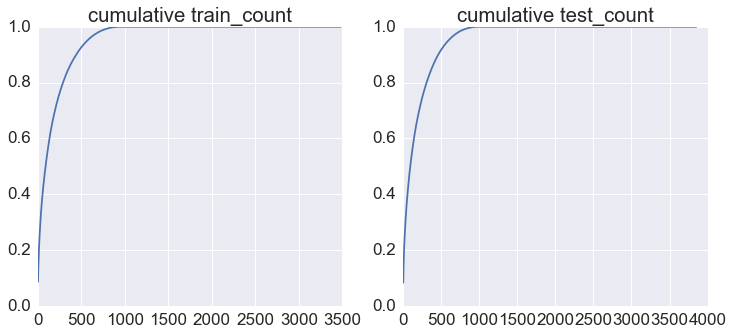

In [86]:
fig, axes = plt.subplots(1,2, figsize = (12,5))
temp = df_managers['train_count'].dropna().sort_values(ascending = False).reset_index(drop = True)
axes[0].plot(temp.index+1, temp.cumsum()/temp.sum())
axes[0].set_title('cumulative train_count')

temp = df_managers['test_count'].dropna().sort_values(ascending = False).reset_index(drop = True)
axes[1].plot(temp.index+1, temp.cumsum()/temp.sum())
axes[1].set_title('cumulative test_count')
plt.savefig('cs559_2.jpg')

In [79]:
man_list = df_managers['train_count'].sort_values(ascending = False).head(50).index
ixes = train.manager_id.isin(man_list)
df100 = train[ixes][['manager_id','interest_level']]
interest_dummies = pd.get_dummies(df100.interest_level)
df100 = pd.concat([df100,interest_dummies[['low','medium','high']]], axis = 1).drop('interest_level', axis = 1)

In [80]:
gby = pd.concat([df100.groupby('manager_id').mean(),df100.groupby('manager_id').count()], axis = 1).iloc[:,:-2]
gby.columns = ['low','medium','high','count']
gby.sort_values(by = 'count', ascending = False).head(10)

,low,medium,high,count
manager_id,,,,
3959,0.686538,0.245559,0.067904,2533
1883,0.905767,0.088608,0.005626,711
2452,0.987805,0.009756,0.002439,410
3510,0.361930,0.490617,0.147453,373
2714,0.827273,0.130303,0.042424,330
760,0.515823,0.363924,0.120253,316
2991,0.918033,0.078689,0.003279,305
565,0.349481,0.415225,0.235294,289
3632,0.804348,0.192029,0.003623,276


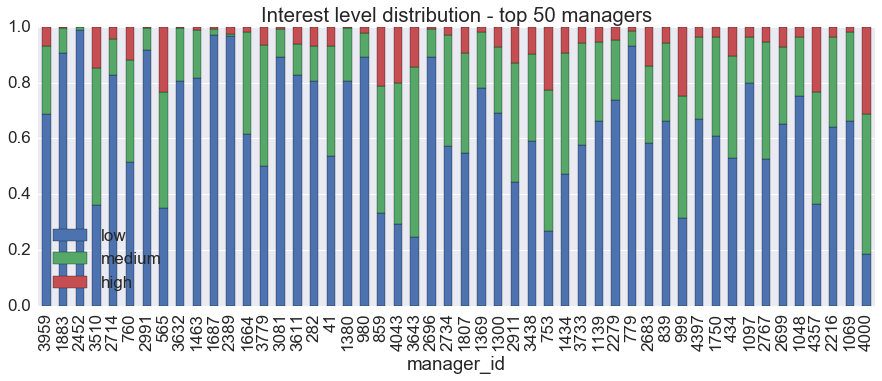

In [84]:
gby.sort_values(by = 'count', ascending = False).drop('count', axis = 1).plot(kind = 'bar', stacked = True, figsize = (15,5))
plt.title('Interest level distribution - top 50 managers')
plt.savefig('cs559_1.jpg')

# Modeling

In [63]:
fe =  ['bathrooms', 'bedrooms', 'latitude', 'longitude', 'price', 'day_diff', 'photos_counts', 'description_word_count'
      , "display_address", "manager_id", "building_id", "street_address", 'listing_id', 'time_stamp']

In [64]:
fe2 = list(range(200))

In [65]:
fe3 = ['total_room','price_per_room', 'manager_listings','listings_by_month_4_perc',
       'listings_by_month_5_perc','listings_by_month_6_perc','average_price_by_manager',
       'price_by_month_4','price_by_month_5','price_by_month_6', 'listing_count_high_perc',
      'listing_count_medium_perc','listing_count_low_perc', 'listing_count',
       'price_average_low','price_average_medium','price_average_high','price_median_low',
       'price_median_medium','price_median_high']

In [66]:
col = fe + fe2 + fe3

In [67]:
col.append('interest_level')

In [68]:
train_x = train_new[col]
test_x = test[col]

In [69]:
train_x = train_x.drop([ 'interest_level'], axis = 1)
test_x = test_x.drop([ 'interest_level'], axis = 1)


In [70]:
train_y = train_new['interest_level'].map({'low':2, 'medium':1, 'high':0})

In [71]:
%store total

Stored 'total' (DataFrame)


In [72]:
total.to_csv('total.csv')

## XGBoost

In [73]:
def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=0, num_rounds=1000):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.03
    param['max_depth'] = 6
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    num_rounds = num_rounds

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest)
    return pred_test_y, model


In [74]:
for x in ['manager_listings',
 'listings_by_month_4_perc',
 'listings_by_month_5_perc',
 'listings_by_month_6_perc',
 'average_price_by_manager',
 'price_by_month_4',
 'price_by_month_5',
 'price_by_month_6','listing_count_alllevel',
 'price_average_low',
 'price_average_medium',
 'price_average_high',
 'price_median_low',
 'price_median_medium',
 'price_median_high',
 'interest_level']:
    col.remove(x)


ValueError: list.remove(x): x not in list

In [ ]:
%%time
##Round 3
p, model = runXGB(train_x, train_y, test_x, num_rounds=2000)
out_df = pd.DataFrame(p)
out_df.columns = ["high", "medium", "low"]
out_df["listing_id"] = test.listing_id.values
out_df.to_csv("xgb_3.csv", index=False)

In [ ]:
%%time
p, model = runXGB(train_x, train_y, test_x, num_rounds=2000)

In [ ]:
out_df = pd.DataFrame(p)
out_df.columns = ["high", "medium", "low"]
out_df["listing_id"] = test.listing_id.values
out_df.to_csv("xgb_1.csv", index=False)

In [ ]:
## rounds = 1000, step = 0.03

In [ ]:
%%time
p, model = runXGB(train_x, train_y, test_x, num_rounds=1000)

In [ ]:
out_df = pd.DataFrame(p)
out_df.columns = ["high", "medium", "low"]
out_df["listing_id"] = test.listing_id.values
out_df.to_csv("xgb_2.csv", index=False)

In [ ]:
### rounds = 1000, step = 0.03

In [ ]:
%%time
cv_scores = []
kf = KFold(n_splits=5, shuffle=True, random_state=2016)
for dev_index, val_index in kf.split(range(train_x.shape[0])):
        dev_X, val_X = train_x.ix[dev_index,:], train_x.ix[val_index,:]
        dev_y, val_y = train_y.ix[dev_index], train_y.ix[val_index]
        preds, model = runXGB(dev_X, dev_y, val_X, val_y)
        cv_scores.append(log_loss(val_y, preds))
        print(cv_scores)
        break

In [ ]:
### rounds = 2000, step = 0.02

In [ ]:
%%time
cv_scores = []
kf = KFold(n_splits=5, shuffle=True, random_state=2016)
for dev_index, val_index in kf.split(range(train_x.shape[0])):
        dev_X, val_X = train_x.ix[dev_index,:], train_x.ix[val_index,:]
        dev_y, val_y = train_y.ix[dev_index], train_y.ix[val_index]
        preds, model = runXGB(dev_X, dev_y, val_X, val_y)
        cv_scores.append(log_loss(val_y, preds))
        print(cv_scores)
        break

## Store result 1

In [ ]:
%store p

In [ ]:
%store train_x

In [ ]:
%store test_x

# Stacking

In [ ]:
## https://www.kaggle.com/mmueller/allstate-claims-severity/stacking-starter/run/390867

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

In [ ]:
train_st = train_x.copy()
test_st = test_x.copy()

In [ ]:
train_st.shape

In [ ]:
test_st.shape

In [ ]:
ntrain = train_st.shape[0]
ntest = test_st.shape[0]

In [ ]:
train_test = pd.concat((train_st, test_st)).reset_index(drop=True)

In [ ]:
x_train = np.array(train_test.iloc[:ntrain,:])
x_test = np.array(train_test.iloc[ntrain:,:])
y_train = train_y

In [ ]:
NFOLDS = 5
SEED = 0
kf = KFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)

In [ ]:
class SklearnWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def fit2(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict2(self, x):
        return self.clf.predict_proba(x)


In [ ]:
class XgbWrapper(object):
    def __init__(self, seed=0, params=None):
        self.param = params
        self.param['seed'] = seed
        self.nrounds = params['nrounds']

    def fit2(self, x_train, y_train):
        dtrain = xgb.DMatrix(x_train, label=y_train)
        self.gbdt = xgb.train(self.param, dtrain, self.nrounds)

    def predict2(self, x):
        return self.gbdt.predict(xgb.DMatrix(x))

In [ ]:
def get_oof(clf, xtrain, ytrain, xtest):
    oof_train = np.zeros((ntrain,3))
    oof_test = np.zeros((ntest,3))
    oof_test_temp =  np.zeros((ntest,3))
    for i, (train_index, test_index) in enumerate(kf.split(xtrain)):
        x_tr = xtrain.iloc[train_index]
        x_te = xtrain.iloc[test_index]
        y_tr = ytrain.iloc[train_index]
        
        clf.fit2(x_tr, y_tr)
        oof_train[test_index] = clf.predict2(x_te)
        oof_test_temp = clf.predict2(xtest)
        oof_test = oof_test + oof_test_temp
    oof_test = oof_test / NFOLDS
    return oof_train, oof_test

In [ ]:
## http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier
et_params = {
    'n_jobs': -1,
    'n_estimators': 1000,
    'max_features': 0.5,
    'max_depth': 10,
    'min_samples_leaf': 2,
}

In [ ]:
%%time
et_oof_train, et_oof_test = get_oof(et, train_st_sklearn, y_train, test_st_sklearn)

In [ ]:
et_oof_train.shape

In [ ]:
et_oof_train[:5]

In [ ]:
## http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
rf_params = {
    'n_jobs': 16,
    'n_estimators': 1000,
    'max_features': 0.5,
    'max_depth': 10,
    'min_samples_leaf': 2,
}

In [ ]:
%%time
rf_oof_train, rf_oof_test = get_oof(rf, train_st_sklearn, y_train, test_st_sklearn)

In [ ]:
rf_oof_train.shape

In [ ]:
rf_oof_train[:5]

In [ ]:
## http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier
knn_params = {}
knn_params['n_neighbors'] = 5
# knn_params['']
# knn_params
# knn_params
# knn_params
# knn_params

In [ ]:
class KNN(object):
    def __init__(self, clf, seed=0, params=None):
        
        self.clf = clf(**params)

    def fit2(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict2(self, x):
        return self.clf.predict_proba(x)


In [ ]:
knn = KNN(clf=KNeighborsClassifier, seed=SEED, params=knn_params)

In [ ]:
%%time
knn_oof_train, knn_oof_test = get_oof(knn, train_st_sklearn, y_train, test_st_sklearn)

In [ ]:
## http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
svm_params = {}
svm_params['C'] = 1.0
svm_params['probability'] = True

In [ ]:
svm = SklearnWrapper(clf=SVC, seed=SEED, params=svm_params)

In [ ]:
## http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier
nn_params = {}
nn_params['hidden_layer_sizes'] = 100
nn_params['activation'] = 'relu'
nn_params['alpha'] = 0.001
nn_params['max_iter'] = 5000
nn_params['random_state'] = SEED
nn_params['learning_rate_init'] = 0.01
nn_params['early_stopping'] = False


In [ ]:
nn = SklearnWrapper(clf=MLPClassifier, seed=SEED, params=nn_params)

In [ ]:
%%time
nn_oof_train, nn_oof_test = get_oof(nn, train_st_sklearn, y_train, test_st_sklearn)

In [ ]:
nn_oof_train

In [ ]:
xgb_params = {}
xgb_params['objective']='multi:softprob'
xgb_params['eta']=0.03
xgb_params['max_depth']=6
xgb_params['silent']=1
xgb_params['num_class']=3
xgb_params['eval_metric']="mlogloss"
xgb_params['min_child_weight']=1
xgb_params['subsample']=0.7
xgb_params['colsample_bytree']=0.7
xgb_params['seed']=0
xgb_params['nrounds']=1000


In [ ]:
xg = XgbWrapper(seed=SEED, params=xgb_params)
et = SklearnWrapper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
rf = SklearnWrapper(clf=RandomForestClassifier, seed=SEED, params=rf_params)

In [ ]:
train_st_sklearn = train_st.copy()
test_st_sklearn = test_st.copy()

In [ ]:
test_st_sklearn = test_st_sklearn.replace(np.inf, np.nan)
train_st_sklearn = train_st_sklearn.replace(np.inf, np.nan)

In [ ]:
train_st_sklearn = train_st_sklearn.fillna(train_st_sklearn.median())

test_st_sklearn = test_st_sklearn.fillna(test_st_sklearn.median())

In [ ]:
%%time
xg_oof_train, xg_oof_test = get_oof(xg, train_x, train_y, test_x)

In [ ]:
xg_oof_train.shape

In [ ]:
xg_oof_test.shape

In [ ]:
x_train_after_stack = np.concatenate((xg_oof_train, et_oof_train, rf_oof_train), axis=1)
x_test_after_stack = np.concatenate((xg_oof_test, et_oof_test, rf_oof_test), axis=1)

In [ ]:
%%time
p, model = runXGB(x_train_after_stack, train_y, x_test_after_stack, num_rounds=1000)
out_df = pd.DataFrame(p)
out_df.columns = ["high", "medium", "low"]
out_df["listing_id"] = test.listing_id.values
out_df.to_csv("xgb_4.csv", index=False)

## Add more models for stack 1

In [ ]:
%store 